Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Skin Cancer Data

#### Importing all the important libraries

In [1]:
# Importing all required Libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
import Augmentor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D


import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
# Calculating the total images in train and test folder

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train Image Count:',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test Image Count:',image_count_test)

Train Image Count: 2239
Test Image Count: 118


#### Create a dataset

Define some parameters for the loader:

In [99]:
batch_size = 32
img_height = 180
img_width = 180

Let's load these images off disk using the helpful image_dataset_from_directory utility using keras.preprocessing             
Use 80% of the images for training, and 20% for validation.

In [100]:
## train dataset
## We have used seed=123 while creating train dataset using tf.keras.preprocessing.image_dataset_from_directory
## We have also resized the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None, batch_size= batch_size, image_size=(img_height, img_width), seed= 123,
    validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [101]:
## validation dataset
## We have used seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## We have also resized the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None, batch_size= batch_size, image_size=(img_height, img_width), seed= 123,
    validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List of all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


These are the 9 classes mentioned in the dataset with their respective images 

#### Visualize the data
One instance of all the nine classes present in the dataset

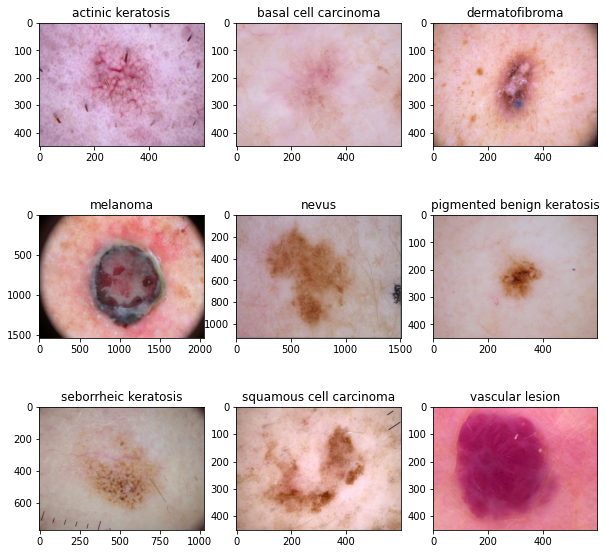

In [10]:
### We have used training data to visualize image from all the nine classes
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    class_image = plt.imread(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0])
    plt.title(class_names[i])
    plt.imshow(class_image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [102]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1
- We have Used ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [103]:
### Model 1 - 1st Basic Model
number_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3))])

# 1st Convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation= 'relu', input_shape=(img_height,img_width,16), padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))

# 2nd Convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))

# 3rd Convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))
          
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation = 'relu'))
model.add(Dense(number_classes, activation = 'softmax'))

#### Compile the model 

In [104]:
### Optimizer we choose is Adam and loss function as sparse categorical crossentropy
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [105]:
# View the summary of all layers
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 45, 45, 64)      

#### Train the model

In [106]:
# Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 88ms/step - loss: 1.8948 - accuracy: 0.3147 - val_loss: 1.6362 - val_accuracy: 0.4318
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5602 - accuracy: 0.4420 - val_loss: 1.4465 - val_accuracy: 0.5168
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4047 - accuracy: 0.5061 - val_loss: 1.3638 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3081 - accuracy: 0.5301 - val_loss: 1.3362 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1656 - accuracy: 0.5982 - val_loss: 1.3417 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.0689 - accuracy: 0.6406 - val_loss: 1.3115 - val_accuracy: 0.5727
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 0.9655 - accuracy: 0.6540 - val_loss: 1.6358 - val_accuracy: 0.5391
Epoch 8/20
5

#### Visualizing training results

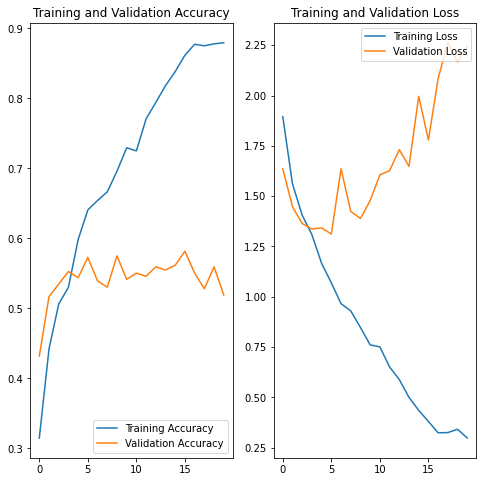

In [107]:
acc = history.history['accuracy']    #list of training accuracy 
val_acc = history.history['val_accuracy']         #list of validation accuracy 

loss = history.history['loss']      #list of training loss
val_loss = history.history['val_loss']     #list of validation loss

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of the 1st Model

Training Accuracy :   **87.95%**                                 
Validation Accuracy : **51.90%**                               
                                      
This is a clear case of **Overfitting** as the train accuracy is good and increases with increase in epochs but very poor accuracy when it comes to Validation dataset.                   
This can also be visualised in the grapgh above where         
1st Graph shows how the Training Accuracy is increasing in the Blue line and Validation Accuracy in Orange line is very low and not increasing.      
2nd Graph shows how the Training Loss is decreasing steadily in the Blue line whereas Validation Loss in Orange line started to decrease but then fluctuates and increases as well.


As we know that the Model is overfitting and we also have less Data with us let's try to fix it by increasing the diversity of our training set using Augmentation techniques and add a layer of it the Model.

Data Augmentation:                             
Data augmentation can help an image ML model learn to handle variations of the image that are not in the training dataset. For example, it is likely that images provided to an ML model will vary quite considerably in terms of lighting or the angle at which they were taken. We can therefore increase the effective size of the training dataset and make the ML model more resilient if we augment the training dataset by randomly changing the brightness, contrast, saturation,flipping the image, rotating the image at a certain angle etc.                     

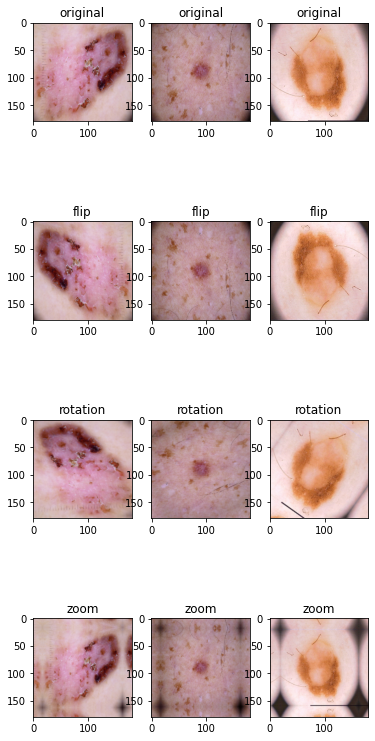

In [20]:
# Here we have used 3 data augmentation techniques Flip, Rotation and Zoom 

flip = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
rotation = layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect')
zoom = layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect') 

# Visualize images and augmentations
fig, ax = plt.subplots(4, 3, figsize=(6,14))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # flip
        ax[1][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("flip")
        # rotation
        ax[2][i].imshow(rotation(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("rotation")
        # zoom
        ax[3][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("zoom")
plt.show()

The Images above goves us an insight of the 3 techniques which we will use in the Model
If we look at these images closely, flip has just flipped the image, rotation has rotated the image to the angle we provided and zoom has also changed the size, we can either zoom in our zoom out.

### Model 2 with Augmentation Layer

In [111]:
# Model 2

# Augmentation Layer
data_augmentation_layer = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                               layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect'), 
                                               layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

model = Sequential([data_augmentation_layer, layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3))])

# 1st Convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation= 'relu', input_shape=(img_height,img_width,16), padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 2nd Convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 3rd Convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 4th Convolutional layer
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(number_classes, activation = 'softmax'))

#### Compile the Model

In [112]:
### Optimizer we choose is Adam and loss function as sparse categorical crossentropy
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Train the Model

In [113]:
# Training for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 60ms/step - loss: 2.2057 - accuracy: 0.1814 - val_loss: 2.1262 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0545 - accuracy: 0.1881 - val_loss: 2.1040 - val_accuracy: 0.2215
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0344 - accuracy: 0.1908 - val_loss: 2.0930 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0340 - accuracy: 0.1992 - val_loss: 2.0776 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.9939 - accuracy: 0.2461 - val_loss: 2.0274 - val_accuracy: 0.2864
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.8762 - accuracy: 0.3237 - val_loss: 1.8453 - val_accuracy: 0.3490
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7567 - accuracy: 0.3845 - val_loss: 1.7617 - val_accuracy: 0.3781
Epoch 8/20
56

#### Visualizing training results

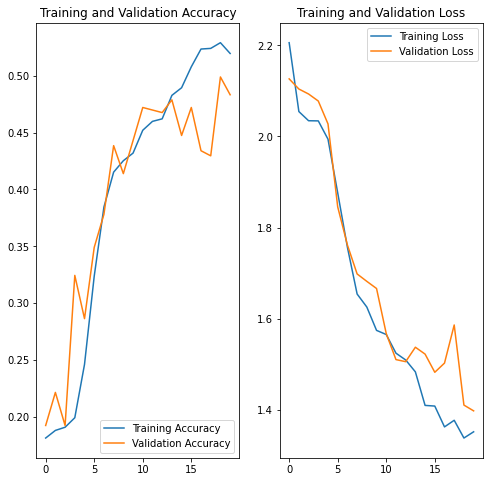

In [114]:
acc = history.history['accuracy']    #list of training accuracy 
val_acc = history.history['val_accuracy']         #list of validation accuracy 

loss = history.history['loss']      #list of training loss
val_loss = history.history['val_loss']     #list of validation loss

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of the 2nd Model

Training Accuracy :   **51.95%**                                 
Validation Accuracy : **48.32%**                               
                                      
As we can see that the Accuracy has significantly dropped when we compare it with our 1st Model but adding an Augmentation layer to our Model has solved the problem of Overfitting as there is no big difference in Train and Validation accuracy.             
**Right now our Model is Underfitting with poor Train and Validation Accuracy**

Lets visualise the grapgh above         
1st Graph shows how the Training Accuracy is increasing in the Blue line and Validation Accuracy in Orange line is also showing the same pattern.
2nd Graph shows how the Training Loss is decreasing steadily in the Blue line and Validation Loss in Orange line is also showing the same pattern.

Model has improved in terms of solving the problem of Overfitting and now we will have to be on the same path to improve our Model Accuracy.

#### Let's find out the distribution of classes in the training dataset.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.                       
Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.     

In [116]:
# We will be creating a dataframe with all the images from different classes to check for distribution
path_list_orginal = [x for x in data_dir_train.glob('*/*.jpg')]
lesion_list_orignial = []
for classname in class_names:
    for files in data_dir_train.glob(classname + '*/*.jpg'):
        lesion_list_orignial.append(classname)
dataframe_dict_org = dict(zip(path_list_orginal, lesion_list_orignial))
original_df = pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])
print('The Number of Images in Each Class:')
original_df['Label'].value_counts()

The Number of Images in Each Class:


pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

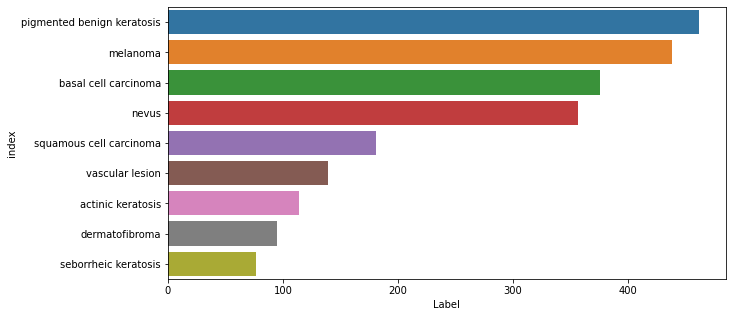

In [120]:
# Visualizing the number of images in each class
plt.figure(figsize=(10, 5))
sns.barplot(y = original_df['Label'].value_counts().reset_index()['index'], x = original_df['Label'].value_counts().reset_index()['Label'], data = original_df)

plt.show()

#### Findings of Class Distribution                     
**"seborrheic keratosis"** has least number of samples.           
**"pigmented benign keratosis"** dominate the train data in terms of proportionate number of samples.


Now as we know that Underfitting as in Poor Model Accuracy and Class Imbalance are the problems we need to deal with hence we will be using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples which can fix these issues and help getting better Model Performance.

In [52]:
!pip install Augmentor  #Installed Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


The purpose of Augmentor is to automate image augmentation (artificial data generation) in order to expand datasets as input for machine learning algorithms, especially neural networks and deep learning. The package works by building an augmentation pipeline where we define a series of operations to perform on a set of images.

In [118]:
path_to_training_dataset="/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10) #Rotate is being used as a technique 
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0BC2484050>: 100%|██████████| 500/500 [00:23<00:00, 21.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0B24049E90>: 100%|██████████| 500/500 [00:22<00:00, 22.25 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0BC21BB150>: 100%|██████████| 500/500 [00:20<00:00, 23.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0B1A697250>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=957x640 at 0x7F0B5E07AFD0>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0BC8CD6850>: 100%|██████████| 500/500 [00:20<00:00, 23.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0B5E097350>: 100%|██████████| 500/500 [00:49<00:00, 10.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0B922E24D0>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment_1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B5E0B0110>: 100%|██████████| 500/500 [00:24<00:00, 20.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [121]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)  # 4500 images stored in Output Sub-Directory

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [122]:
# Creating a new dataframe for the New Images added with the help of Augmentor
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [123]:
df2['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
basal cell carcinoma          500
actinic keratosis             500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
nevus                         500
seborrheic keratosis          500
Name: Label, dtype: int64

As we can see each of the 9 classes have new 500 images stored.                             
Let's see the total count of images that is the original images we had and adding these 500 images to each class.

In [124]:
new_df = original_df.append(df2) # Appending both the dataframes
new_df = new_df['Label'].value_counts().reset_index().rename(columns = {'index':'Class Name','Label':'Image Count'})
new_df

,Class Name,Image Count
0,pigmented benign keratosis,962
1,melanoma,938
2,basal cell carcinoma,876
3,nevus,857
4,squamous cell carcinoma,681
5,vascular lesion,639
6,actinic keratosis,614
7,dermatofibroma,595
8,seborrheic keratosis,577


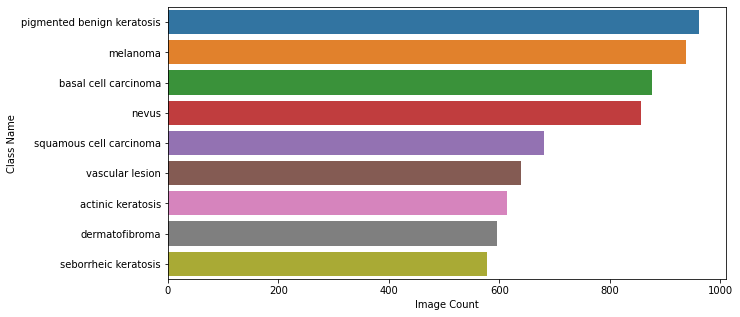

In [125]:
# Visualizing the number of images in each class after using Augmentor
plt.figure(figsize=(10, 5))
sns.barplot(y = new_df['Class Name'], x = new_df['Image Count'], data = new_df)

plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process but we will keep 500 images and continue.                                                       
By adding 500 images to each of the class we have minimized the problem of class imbalance to some extent.                   
                           
Now let's continue and build a Model using this data and check the results.

#### Train the model on the data created using Augmentor

In [6]:
batch_size = 32
img_height = 180
img_width = 180

#### Training dataset

In [7]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Validation dataset

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model 3 with Class rebalance using Augmentor

In [21]:
number_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3))])

# 1st Convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation= 'relu', input_shape=(img_height,img_width,16), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 2nd Convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 3rd Convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 4th Convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

# 5th Convolutional layer
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation= 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(number_classes, activation = 'softmax'))

#### Compile the Model

In [22]:
### Optimizer we choose is Adam and loss function as sparse categorical crossentropy
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Train the Model

In [23]:
# Training the model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 181ms/step - loss: 1.8746 - accuracy: 0.3392 - val_loss: 7.5234 - val_accuracy: 0.1381
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 1.4686 - accuracy: 0.4410 - val_loss: 6.9060 - val_accuracy: 0.2183
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3570 - accuracy: 0.4829 - val_loss: 5.6738 - val_accuracy: 0.2769
Epoch 4/30
169/169 [==============================] - 31s 178ms/step - loss: 1.2539 - accuracy: 0.5295 - val_loss: 1.6239 - val_accuracy: 0.4684
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1180 - accuracy: 0.5770 - val_loss: 1.4781 - val_accuracy: 0.5108
Epoch 6/30
169/169 [==============================] - 31s 179ms/step - loss: 1.0190 - accuracy: 0.6109 - val_loss: 1.4322 - val_accuracy: 0.5427
Epoch 7/30
169/169 [==============================] - 32s 181ms/step - loss: 0.9501 - accuracy: 0.6333 - val_loss: 1.5203 - val_ac

#### Visualize the model results

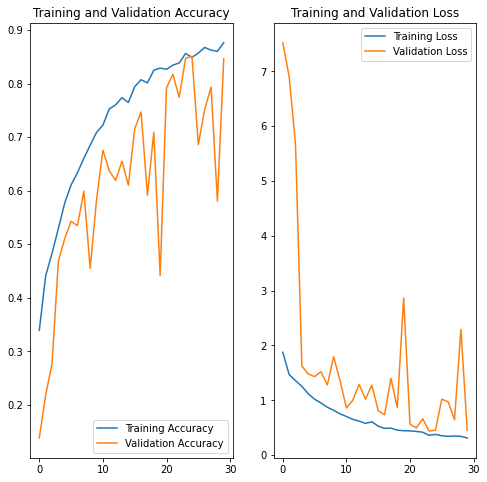

In [24]:
acc = history.history['accuracy']    #list of training accuracy 
val_acc = history.history['val_accuracy']         #list of validation accuracy 

loss = history.history['loss']      #list of training loss
val_loss = history.history['val_loss']     #list of validation loss

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of the 3rd Model

Training Accuracy :   **87.63%**                                 
Validation Accuracy : **84.63%**                               
                                      
As we can see that there is a lot of improvement in the Model train and validation accuracy.We are getting good accuracy on both training and validation dataset.                                         
So by using Augmentor we successfully managed to fix our problem and we were able to achieve good acuuracy.So class rebalance did help us a lot in Model's performance and getting better results.

We were able to generalise our Model and were able to achieve good accuracy on both Training and Validation datatset with no significant difference.